# [과제 2] 회귀분석
### - Ch 1, Ch 2를 토대로 자유롭게 회귀분석과 회귀진단을 진행해주세요.
### - 주석으로 설명 및 근거 자세하게 달아주시면 감사하겠습니다. :)

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings(action='ignore')

# Data 

데이터 출처 : https://www.kaggle.com/avikasliwal/used-cars-price-prediction 

< y > 
* **Price** : The price of the used car in INR Lakhs.



< X > 
* Name : The brand and model of the car
* Location : The location in which the car is being sold or is available for purchase.
* Year : The year or edition of the model.
* Kilometers_Driven : The total kilometres driven in the car by the previous owner(s) in KM.
* Fuel_Type : The type of fuel used by the car. (Petrol, Diesel, Electric, CNG, LPG)
* Transmission : The type of transmission used by the car. (Automatic / Manual)
* Owner_Type : Whether the ownership is Firsthand, Second hand or other.
* Mileage : The standard mileage offered by the car company in kmpl or km/kg
* Engine : The displacement volume of the engine in CC.
* Power : The maximum power of the engine in bhp.
* Seats : The number of seats in the car.
* New_Price : The price of a new car of the same model.

In [2]:
# Load Data 
data = pd.read_csv("assignment2_data.csv", index_col=0)
print(f"data shape:", data.shape)
data.head()

data shape: (6019, 13)


,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,New_Price,Price
0,Maruti Wagon R LXI CNG,Mumbai,2010,72000,CNG,Manual,First,26.6 km/kg,998 CC,58.16 bhp,5.0,NaN,1.75
1,Hyundai Creta 1.6 CRDi SX Option,Pune,2015,41000,Diesel,Manual,First,19.67 kmpl,1582 CC,126.2 bhp,5.0,NaN,12.50
2,Honda Jazz V,Chennai,2011,46000,Petrol,Manual,First,18.2 kmpl,1199 CC,88.7 bhp,5.0,8.61 Lakh,4.50
3,Maruti Ertiga VDI,Chennai,2012,87000,Diesel,Manual,First,20.77 kmpl,1248 CC,88.76 bhp,7.0,NaN,6.00
4,Audi A4 New 2.0 TDI Multitronic,Coimbatore,2013,40670,Diesel,Automatic,Second,15.2 kmpl,1968 CC,140.8 bhp,5.0,NaN,17.74


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6019 entries, 0 to 6018
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Name               6019 non-null   object 
 1   Location           6019 non-null   object 
 2   Year               6019 non-null   int64  
 3   Kilometers_Driven  6019 non-null   int64  
 4   Fuel_Type          6019 non-null   object 
 5   Transmission       6019 non-null   object 
 6   Owner_Type         6019 non-null   object 
 7   Mileage            6017 non-null   object 
 8   Engine             5983 non-null   object 
 9   Power              5983 non-null   object 
 10  Seats              5977 non-null   float64
 11  New_Price          824 non-null    object 
 12  Price              6019 non-null   float64
dtypes: float64(2), int64(2), object(9)
memory usage: 658.3+ KB


# Data Preprocessing

- New Price는 NA값이 있는 행이 5195개  
- 86%가 결측치인 열이기 때문에 New_Price 열은 제거

In [4]:
data.isna().sum()

Name                    0
Location                0
Year                    0
Kilometers_Driven       0
Fuel_Type               0
Transmission            0
Owner_Type              0
Mileage                 2
Engine                 36
Power                  36
Seats                  42
New_Price            5195
Price                   0
dtype: int64

In [5]:
5195/len(data)

0.8631001827546104

In [6]:
data.drop(["New_Price"], axis=1, inplace=True)

- Name을 Company, Name으로 분리

In [7]:
data['Company'] = data['Name'].apply(lambda x: x.split()[0])
data['Name'] = data['Name'].apply(lambda x: ' '.join(x.split()[1:]))

- Mileage, Engine, Power의 단위를 모두 제거

In [8]:
def power_unit(x):
    if str(x).split(" ")[0] == 'null':
        return float('nan')
    elif len(str(x).split(" ")) == 2:
        return float(str(x).split(" ")[0])
    else:
        return float('nan')

In [9]:
data['Mileage'] = data['Mileage'].apply(lambda x: float(str(x).split()[0]))
data['Engine'] = data['Engine'].apply(lambda x: float(str(x).split()[0]))
data['Power'] = data['Power'].apply(power_unit)

## Missing Value

In [10]:
data.isna().sum()

Name                   0
Location               0
Year                   0
Kilometers_Driven      0
Fuel_Type              0
Transmission           0
Owner_Type             0
Mileage                2
Engine                36
Power                143
Seats                 42
Price                  0
Company                0
dtype: int64

- 결측치 평균값으로 대체

In [11]:
data = data.fillna(data.mean())

In [12]:
data.isna().sum()

Name                 0
Location             0
Year                 0
Kilometers_Driven    0
Fuel_Type            0
Transmission         0
Owner_Type           0
Mileage              0
Engine               0
Power                0
Seats                0
Price                0
Company              0
dtype: int64

## Outlier

- Location

In [13]:
data['Location'].value_counts()

Mumbai        790
Hyderabad     742
Kochi         651
Coimbatore    636
Pune          622
Delhi         554
Kolkata       535
Chennai       494
Jaipur        413
Bangalore     358
Ahmedabad     224
Name: Location, dtype: int64

- Fuel Type

In [14]:
data['Fuel_Type'].value_counts()

Diesel      3205
Petrol      2746
CNG           56
LPG           10
Electric       2
Name: Fuel_Type, dtype: int64

In [15]:
# LPG와 Electric은 너무 적게 나타나서 이상치로 판단하고 제거
idx =data[(data['Fuel_Type']=='LPG') | (data['Fuel_Type']=='Electric')].index
data.drop(idx, axis=0, inplace=True)

- Transmission

In [16]:
data['Transmission'].value_counts()

Manual       4289
Automatic    1718
Name: Transmission, dtype: int64

- Owner Type

In [17]:
data['Owner_Type'].value_counts()

First             4919
Second             966
Third              113
Fourth & Above       9
Name: Owner_Type, dtype: int64

In [18]:
# Fourth & Above는 너무 적게 나타나서 이상치로 판단하고 제거
idx = data[data['Owner_Type']=='Fourth & Above'].index
data.drop(idx, axis=0, inplace=True)

- Seats

In [19]:
data['Seats'].value_counts()

5.000000     4998
7.000000      672
8.000000      132
4.000000       99
5.278735       41
6.000000       31
2.000000       16
10.000000       5
9.000000        3
0.000000        1
Name: Seats, dtype: int64

<AxesSubplot:xlabel='Seats'>

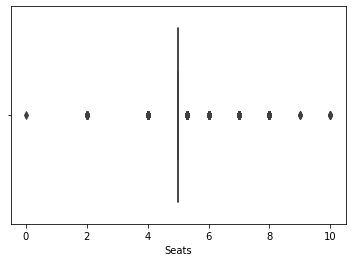

In [20]:
sns.boxplot(data['Seats'])

In [21]:
# Seats 중 8보다 큰 값에 대해서는 8로 변경
data['Seats'] = np.where(data['Seats'] > 8, 8, data['Seats'])

In [22]:
# Seats 중 0값은 너무 적어 이상치로 판단하고 제거
data.drop(data[data['Seats'] == 0].index, axis = 0, inplace = True)

In [23]:
data['Seats'].value_counts()

5.000000    4998
7.000000     672
8.000000     140
4.000000      99
5.278735      41
6.000000      31
2.000000      16
Name: Seats, dtype: int64

- Name

In [24]:
data['Name'].nunique()

1862

- Numeric

In [25]:
data.describe()

,Year,Kilometers_Driven,Mileage,Engine,Power,Seats,Price
count,5997.000000,5.997000e+03,5997.000000,5997.000000,5997.000000,5997.000000,5997.000000
mean,2013.372520,5.861361e+04,18.142873,1621.782337,113.370301,5.276710,9.497879
std,3.261297,9.133024e+04,4.574190,598.978409,53.260367,0.792519,11.201351
min,1998.000000,1.710000e+02,0.000000,624.000000,34.200000,2.000000,0.440000
25%,2011.000000,3.393100e+04,15.200000,1198.000000,78.000000,5.000000,3.500000
50%,2014.000000,5.300000e+04,18.160000,1495.000000,98.600000,5.000000,5.650000
75%,2016.000000,7.300000e+04,21.100000,1969.000000,138.030000,5.000000,9.990000
max,2019.000000,6.500000e+06,33.540000,5998.000000,560.000000,8.000000,160.000000


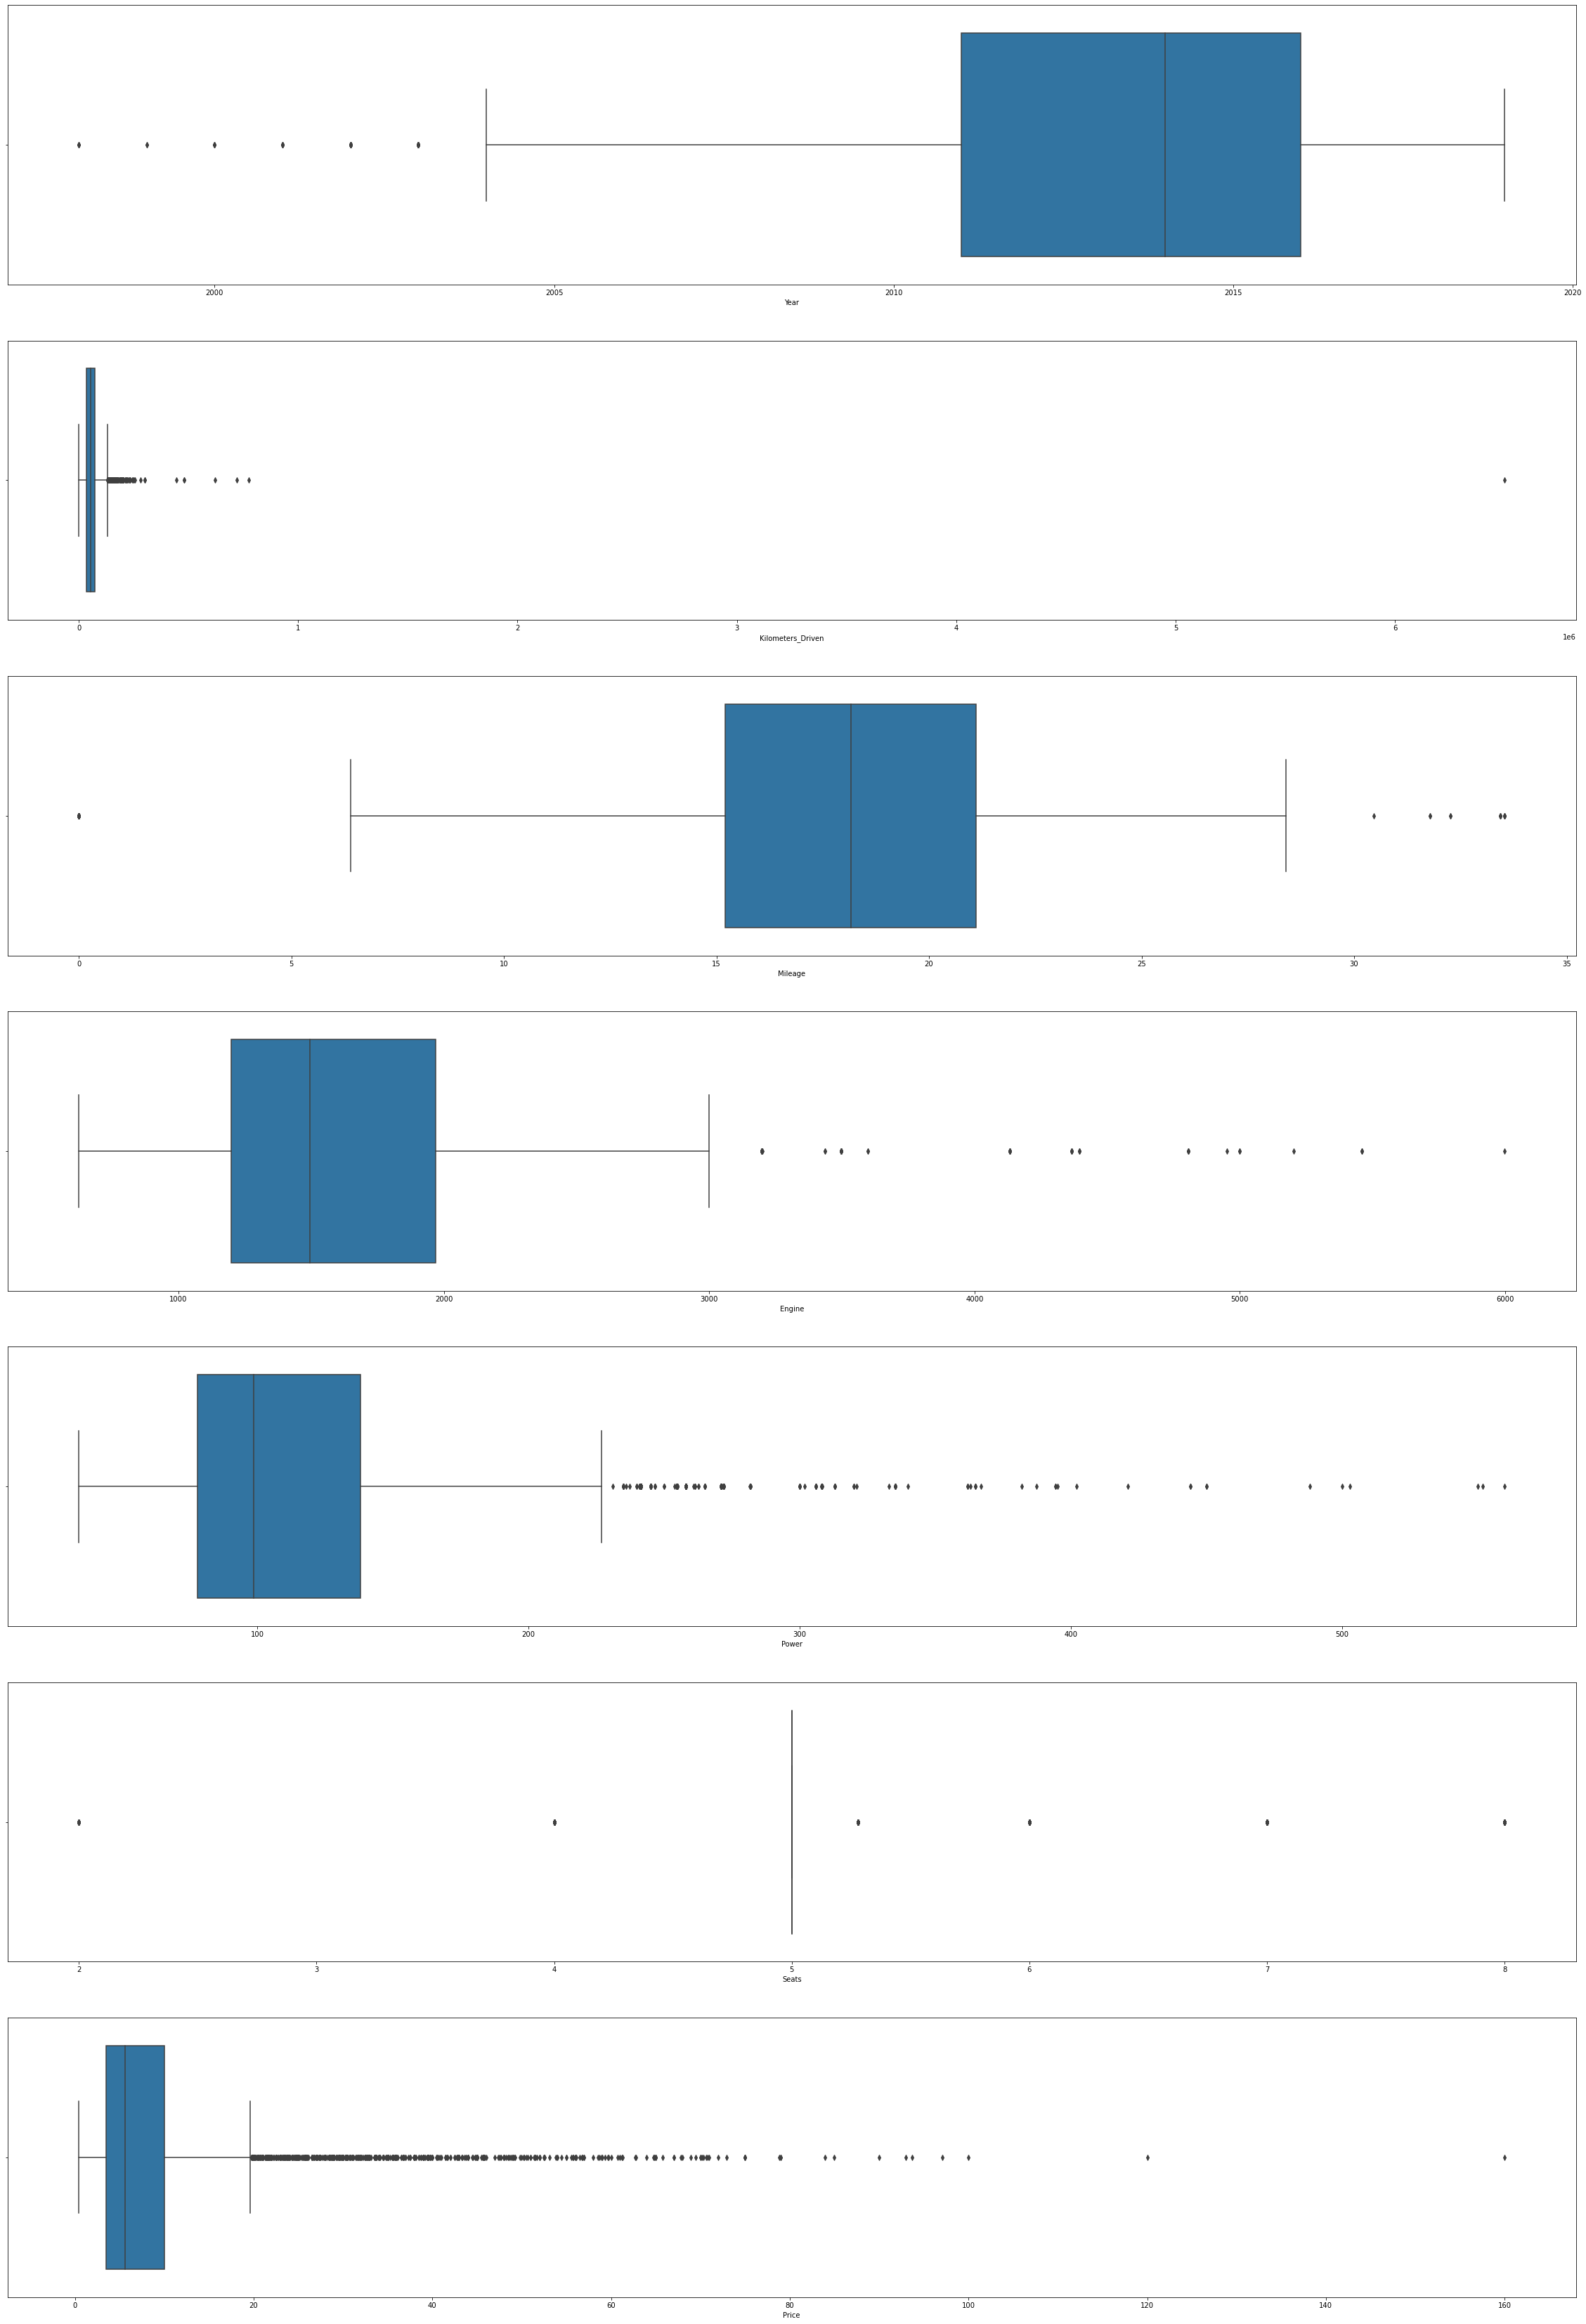

In [26]:
# Check Outiler (Numeric)
num_features = data.select_dtypes(exclude = ['object']).columns

plt.figure(figsize=(40,60))
for i in range(len(num_features)):
    plt.subplot(7,1,i+1)
    sns.boxplot(data[num_features[i]])

- Year

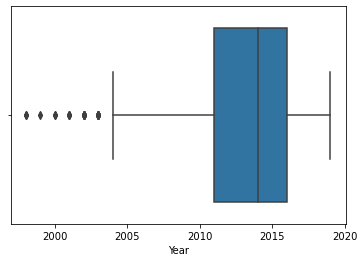

In [27]:
sns.boxplot('Year', data=data)
plt.show()

In [28]:
# Year가 2003보다 작은 연도에 대해서는 임의의 값(2002)으로 치환
data['Year'] = np.where(data['Year']<2003, 2002, data['Year'])

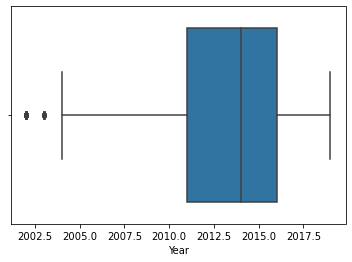

In [29]:
sns.boxplot('Year', data=data)
plt.show()

- Kilometers Driven

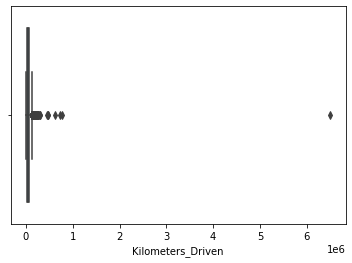

In [30]:
sns.boxplot('Kilometers_Driven', data=data)
plt.show()

In [31]:
# Kilometers_Driven 중 10^6 보다 큰 값은 이상치로 판단하고 제거
data.drop(data[data['Kilometers_Driven'] > 10**6].index, axis = 0, inplace = True)

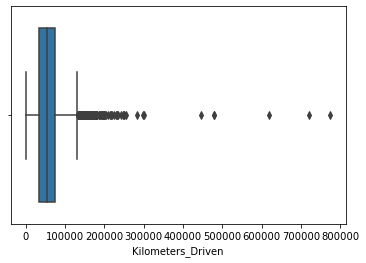

In [32]:
sns.boxplot('Kilometers_Driven', data=data)
plt.show()

- Mileage

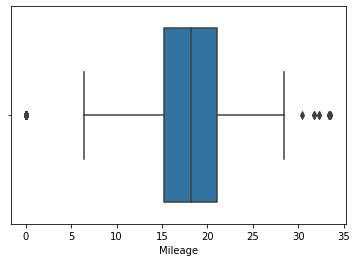

In [33]:
sns.boxplot('Mileage', data=data)
plt.show()

In [34]:
# Mileage 0보다 작거나, 30보다 큰 값은 이상치로 판단하여 치환
# data.drop(data[data['Mileage'] > 30].index, axis = 0, inplace = True)
# data.drop(data[data['Mileage'] < 5].index, axis = 0, inplace = True)
data['Mileage'] = np.where(data['Mileage'] > 30, 30, data['Mileage'])
data['Mileage'] = np.where(data['Mileage'] < 5, 5, data['Mileage'])

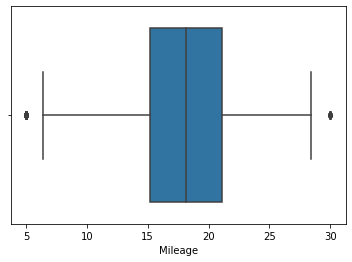

In [35]:
sns.boxplot('Mileage', data=data)
plt.show()

- Engine

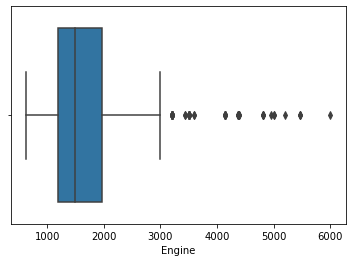

In [36]:
sns.boxplot('Engine', data = data)
plt.show()

In [37]:
# Engine 3000보다 큰 값은 이상치로 판단하여 치환
# data.drop(data[data['Engine'] > 3000].index, axis = 0, inplace = True)
data['Engine'] = np.where(data['Engine'] > 3000, 3000, data['Engine'])

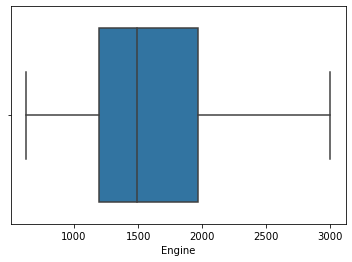

In [38]:
sns.boxplot('Engine', data = data)
plt.show()

- Power

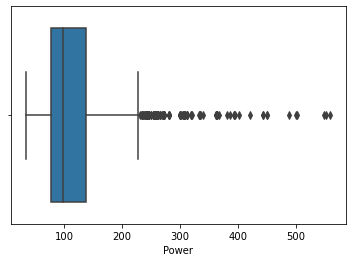

In [39]:
sns.boxplot('Power', data = data)
plt.show()

In [40]:
138 + 1.5*(138-77)

229.5

In [41]:
# Power 230보다 큰 값은 230으로 치환
# data.drop(data[data['Power'] > 230].index, axis = 0, inplace = True)
data['Power'] = np.where(data['Power'] > 230, 230, data['Power'])

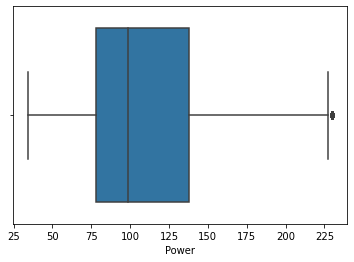

In [42]:
sns.boxplot('Power', data = data)
plt.show()

- Company

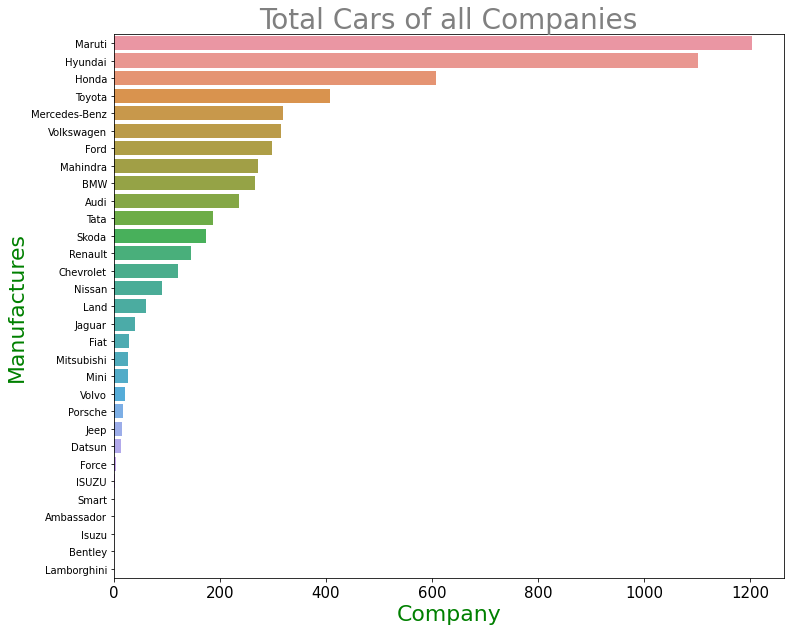

In [43]:
plt.figure(figsize=(12,10))
most_cat = data['Company'].value_counts()
sns.barplot(x = most_cat, y = most_cat.index, data=data)
plt.xticks(size = 15)
plt.xlabel("Company",size = 22,c = "g")
plt.ylabel("Manufactures",size = 22,c = "g")
plt.title("Total Cars of all Companies",size = 28,c = "gray")
plt.show()

In [44]:
data['Company'].value_counts()[data['Company'].value_counts()<5]

Force          3
ISUZU          2
Smart          1
Ambassador     1
Isuzu          1
Bentley        1
Lamborghini    1
Name: Company, dtype: int64

In [45]:
# Bently, Force, Lamborghini, Isuzu는 너무 적기 때문에 삭제
idx = data['Company'].value_counts()[data['Company'].value_counts()<5].index
index = data[data['Company'].isin(idx)].index
data.drop(index, axis = 0, inplace = True)

# Visualization

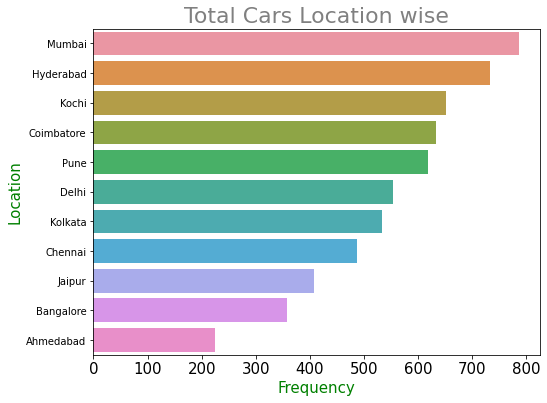

In [46]:
plt.figure(figsize=(8,6))
most_cat = data['Location'].value_counts()
sns.barplot(x = most_cat, y = most_cat.index, data=data)
plt.xticks(size = 15)
plt.xlabel("Frequency", size = 15, c = "g")
plt.ylabel("Location", size = 15, c = "g")
plt.title("Total Cars Location wise", size = 22, c = "gray")
plt.show()

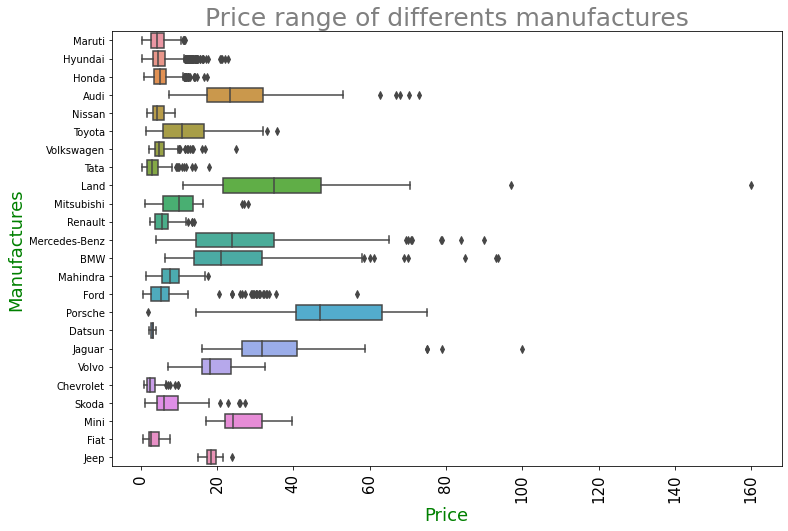

In [47]:
plt.figure(figsize = (12,8))
sns.boxplot(data = data, y = "Company", x = "Price")
plt.xlabel("Price", size = 18, c = "g")
plt.ylabel("Manufactures", size = 18, c = "g")
plt.title("Price range of differents manufactures", size = 25, c = "gray")
plt.xticks(rotation = 'vertical', size = 15)
plt.show()

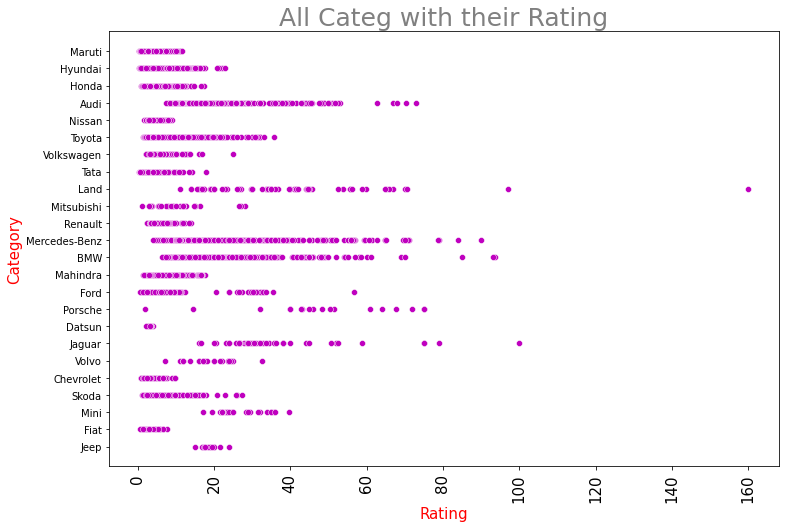

In [48]:
plt.figure(figsize = (12,8)) 
sns.scatterplot(data = data, y = "Company", x = 'Price', color = "m")
plt.xticks(rotation = 'vertical', size = 15)
plt.xlabel("Rating", size = 15, c = "r")
plt.ylabel("Category", size = 15, c = "r")
plt.title("All Categ with their Rating", size=25, c="gray")
plt.show()

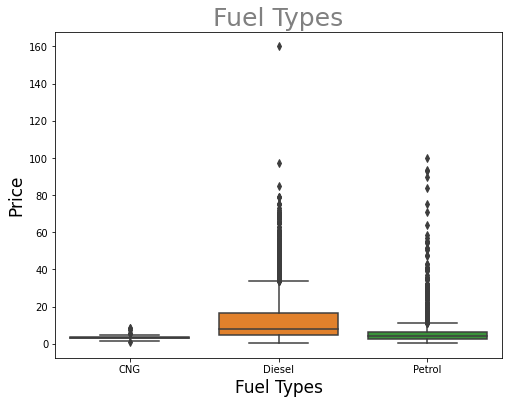

In [49]:
# 디젤이 다른 연료들에 비해 가격이 높은 것을 확인
plt.figure(figsize = (8,6))
sns.boxplot(data = data, x = "Fuel_Type", y = "Price")
plt.xlabel("Fuel Types", size = 17, c = "k")
plt.ylabel("Price", size = 17, c = "k")
plt.title("Fuel Types", size = 25, c = "gray")
plt.show()

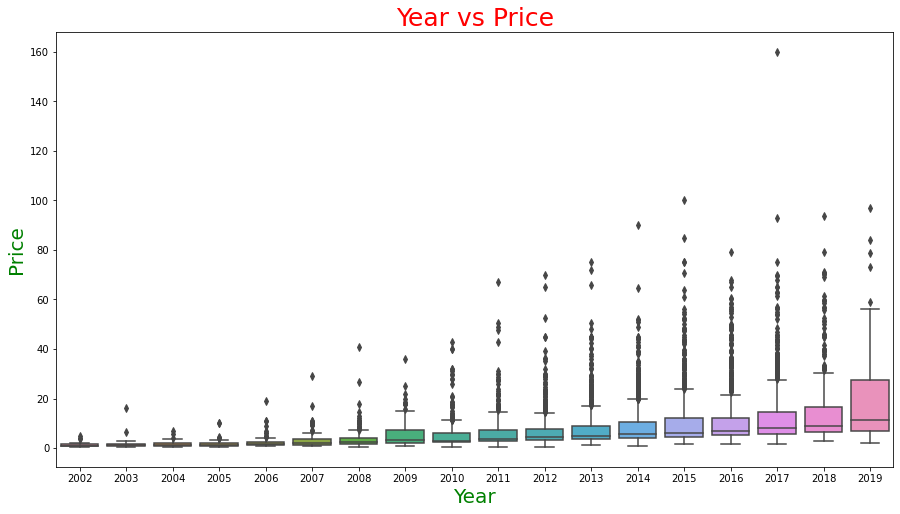

In [50]:
# 시간이 흐를 수록 대체적으로 가격이 비싸지는 것을 확인
plt.figure(figsize = (15,8))
sns.boxplot(data = data, x = "Year", y = "Price")
plt.xlabel("Year", size = 20, c = "g")
plt.ylabel("Price", size = 20, c = "g")
plt.title("Year vs Price", size = 25, c = "r")
plt.show()

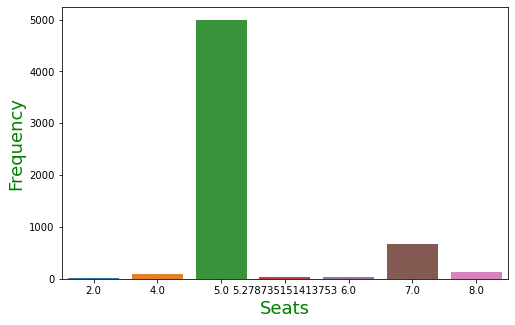

In [51]:
# 좌석이 5인 경우가 다른 경우보다 빈도가 높은 것을 확인
plt.figure(figsize = (8,5))
sns.countplot(data = data, x = "Seats")
plt.xlabel("Seats", size = 18, c = "g")
plt.ylabel("Frequency", size = 18, c = "g")
plt.show()

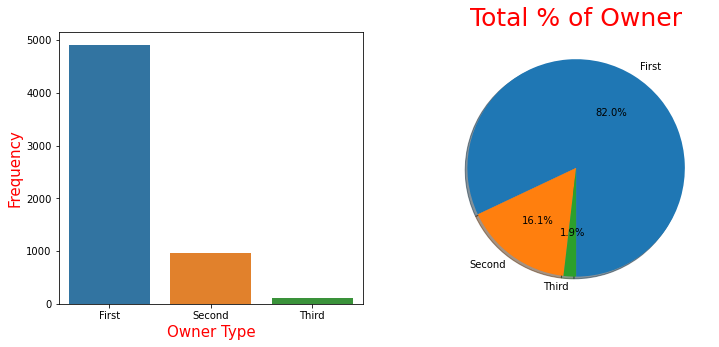

In [52]:
# First Owner의 비중이 가장 높은 것을 확인
plt.figure(figsize = (12,5))
plt.subplot(1,2,1)
sns.countplot(data = data, x = "Owner_Type")
plt.xlabel("Owner Type", size = 15, c = "r")
plt.ylabel("Frequency", size = 15, c = "r")
plt.subplot(1,2,2)
labels = data['Owner_Type'].value_counts(sort = True).index
sizes = data['Owner_Type'].value_counts(sort = True)
plt.pie(sizes, labels = labels, autopct = '%1.1f%%', shadow = True, startangle = 270)
plt.title('Total % of Owner',size = 25, c = "r")
plt.show()

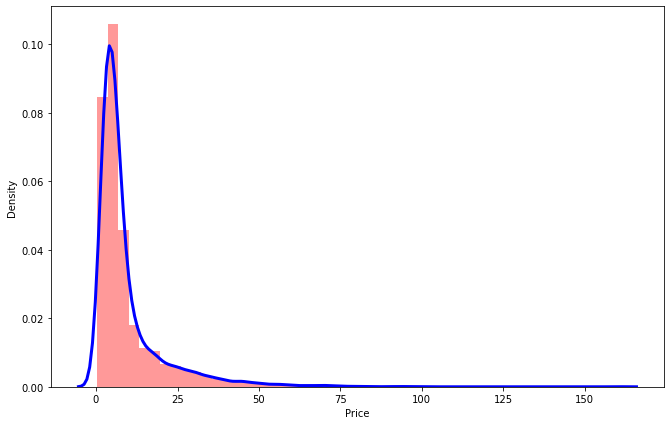

In [53]:
plt.figure(figsize = (11,7))
plt.subplot(1,1,1)
sns.distplot(data['Price'], color = 'r', kde_kws = {'linewidth':3,'color':'b'})
plt.show()

0 Kilometers_Driven
1 Mileage
2 Engine
3 Price


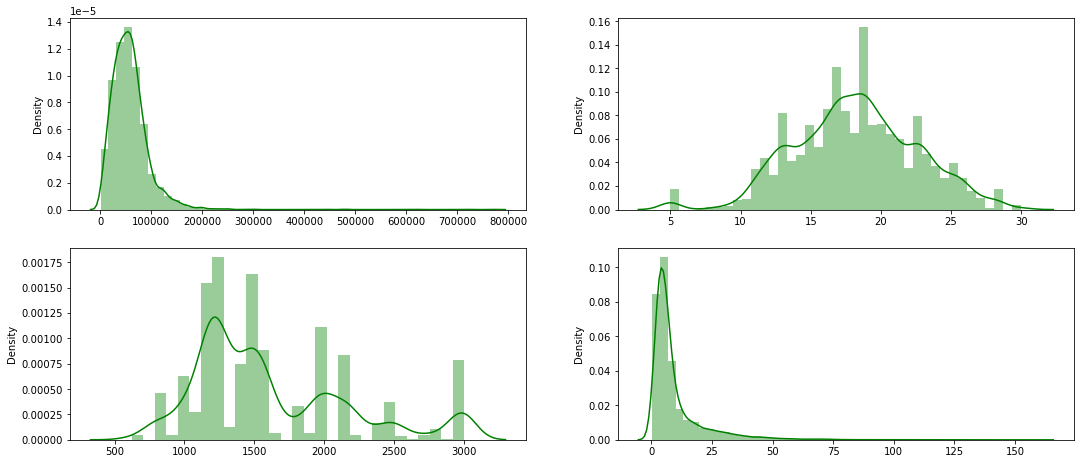

In [54]:
col = ['Kilometers_Driven','Mileage','Engine',"Price"] 
plt.figure(figsize=(18,12))
for i,v in enumerate(col):
    print(i,v)
    plt.subplot(3,2,i+1)
    sns.distplot(x=data[v],color='g')
plt.show()

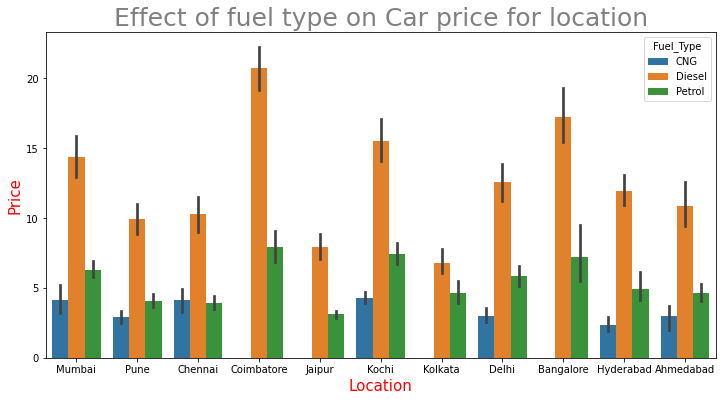

In [55]:
plt.figure(figsize=(12,6))
sns.barplot(data=data,y="Price",x='Location',hue='Fuel_Type')
plt.xlabel("Location",size=15,c="r")
plt.ylabel("Price",size=15,c="r")
plt.title("Effect of fuel type on Car price for location",size=25,c="gray")
plt.show()

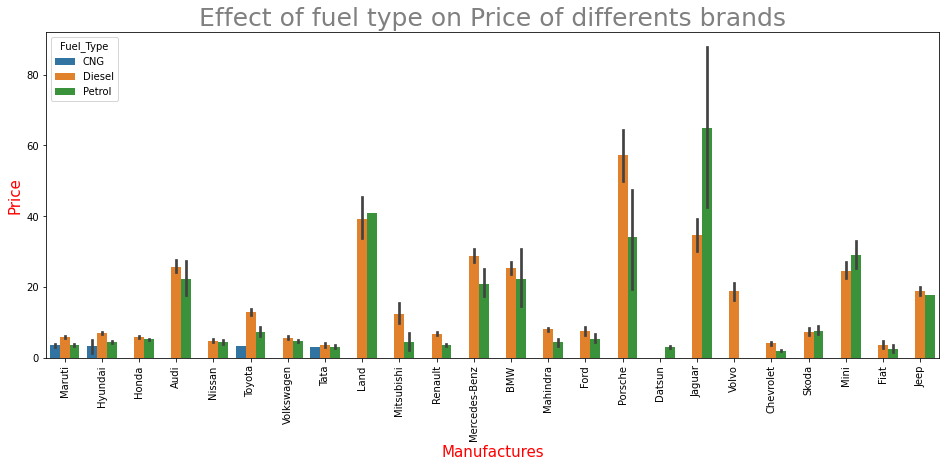

In [56]:
plt.figure(figsize=(16,6))
sns.barplot(data=data,y="Price",x='Company',hue='Fuel_Type')
plt.xlabel("Manufactures",size=15,c="r")
plt.ylabel("Price",size=15,c="r")
plt.xticks(rotation="vertical",size=10)
plt.title("Effect of fuel type on Price of differents brands",size=25,c="gray")
plt.show()

0 Kilometers_Driven
1 Mileage
2 Engine
3 Power


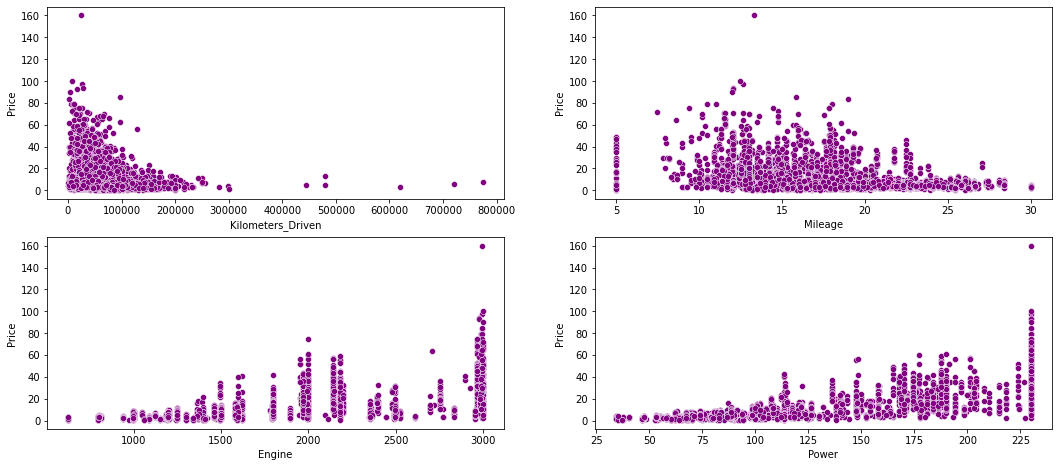

In [57]:
col = ['Kilometers_Driven','Mileage','Engine',"Power"] 
plt.figure(figsize=(18,12))
for i,v in enumerate(col):
    print(i,v)
    plt.subplot(3,2,i+1)
    sns.scatterplot(x=data[v],y=data['Price'],color='purple')
plt.show()

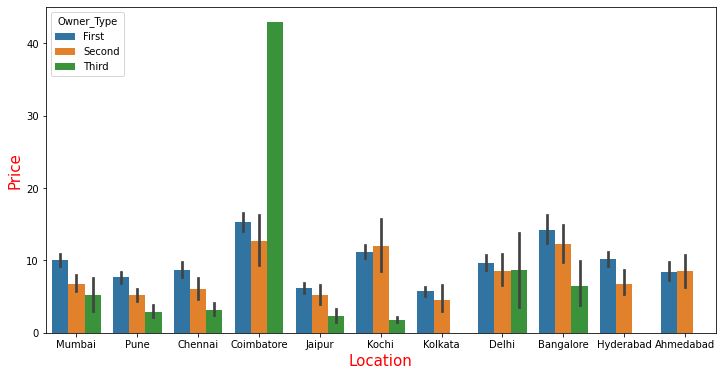

In [58]:
plt.figure(figsize=(12,6))
sns.barplot(data=data,y="Price",x='Location',hue='Owner_Type')
plt.xlabel("Location",size=15,c="red")
plt.ylabel("Price",size=15,c="red")
plt.show()

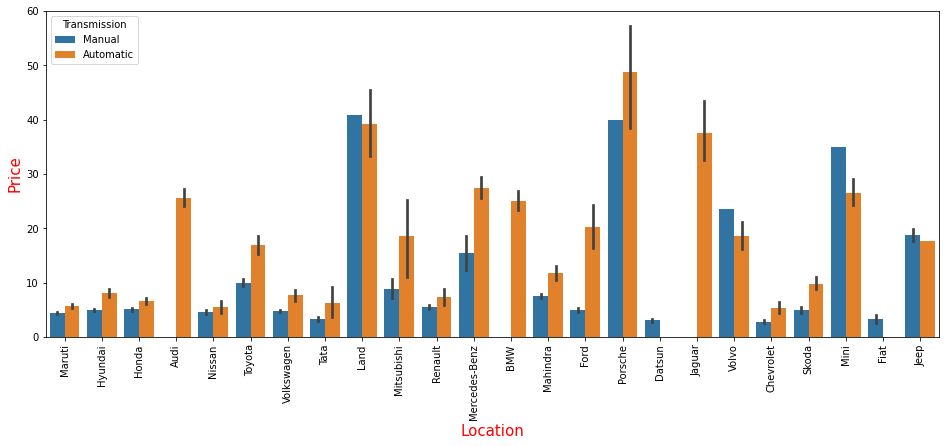

In [59]:
plt.figure(figsize=(16,6))
sns.barplot(data=data,y="Price",x='Company',hue='Transmission')
plt.xlabel("Location",size=15,c="red")
plt.ylabel("Price",size=15,c="red")
plt.xticks(rotation="vertical",size=10)
plt.show()

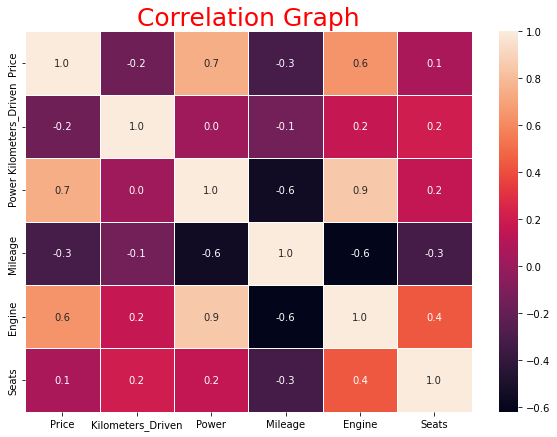

In [60]:
# Power와 Engine은 0.9로 상관관계가 높음 -> 다중공산성 우려 제거
plt.figure(figsize=(10,7))
sns.heatmap(data[["Price","Kilometers_Driven","Power","Mileage","Engine","Seats"]].corr(), annot=True,linewidths=.5,fmt='.1f')
plt.title("Correlation Graph",c="r",size=25)
plt.show()

In [61]:
data = data.drop(['Power'], axis=1)

# Regression Analysis

<AxesSubplot:>

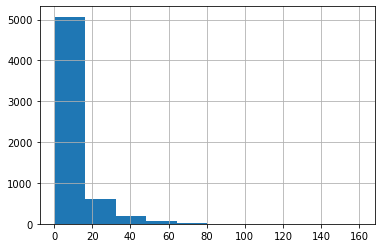

In [62]:
data['Price'].hist()

<AxesSubplot:>

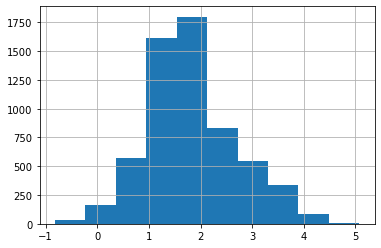

In [63]:
# Price를 로그변환 환 결과 정규분표 형태를 띄는 것을 확인
data['Price'] = np.log(data['Price'])
data['Price'].hist()

<AxesSubplot:>

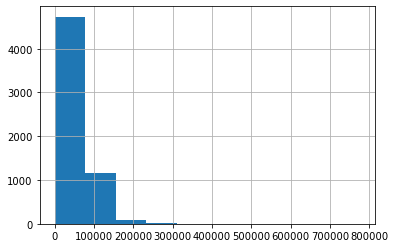

In [64]:
data['Kilometers_Driven'].hist()

<AxesSubplot:>

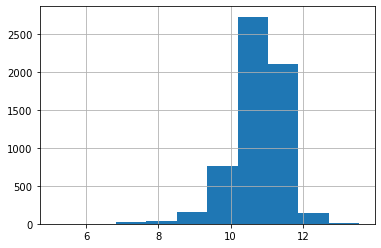

In [65]:
# Kilometers_Driven를 로그변환 환 결과 정규분표 형태를 띄는 것을 확인
data['Kilometers_Driven'] = np.log(data['Kilometers_Driven'])
data['Kilometers_Driven'].hist()

<AxesSubplot:>

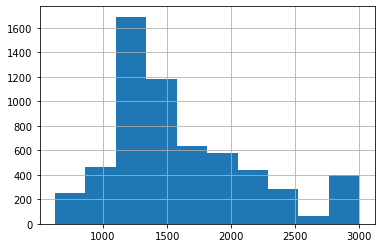

In [66]:
data['Engine'].hist()

<AxesSubplot:>

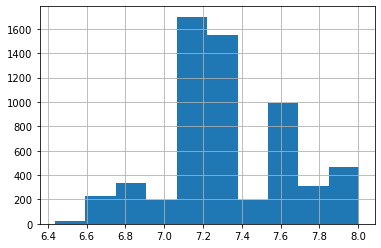

In [67]:
# Engine을 로그변환 환 결과 정규분표 형태를 띄는 것을 확인
data['Engine'] = np.log(data['Engine'])
data['Engine'].hist()

In [68]:
data.describe()

,Year,Kilometers_Driven,Mileage,Engine,Seats,Price
count,5986.000000,5986.000000,5986.000000,5986.000000,5986.000000,5986.000000
mean,2013.380053,10.756587,18.202376,7.328692,5.277051,1.825837
std,3.233295,0.712679,4.351977,0.329565,0.789522,0.872385
min,2002.000000,5.141664,5.000000,6.436150,2.000000,-0.820981
25%,2011.000000,10.432592,15.260000,7.088409,5.000000,1.252763
50%,2014.000000,10.878047,18.160000,7.308543,5.000000,1.730770
75%,2016.000000,11.198215,21.100000,7.584773,5.000000,2.297573
max,2019.000000,13.560618,30.000000,8.006368,8.000000,5.075174


In [69]:
data['Name'] = data['Company'] + " " + data['Name']
data.drop(['Company', 'Engine', 'Seats'], axis = 1, inplace = True)

In [70]:
# 범주형 변수에 One-Hot-Encoding 후 수치형 변수와 병합
cat_features = data.select_dtypes(include=['object']).columns.to_list()
num_features = data.select_dtypes(exclude='object').columns.to_list()

if len(cat_features) > 0:
    data = pd.concat([data[num_features], pd.get_dummies(data[cat_features])], axis=1)
else:
    data = data[num_features]

<AxesSubplot:>

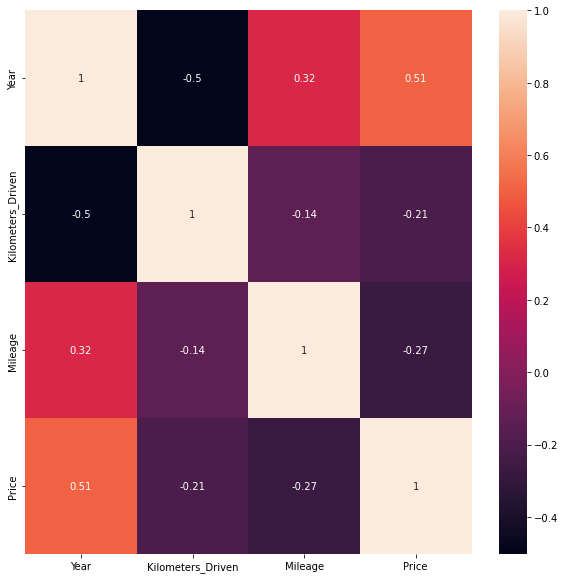

In [71]:
plt.figure(figsize=(10,10))
sns.heatmap(data=data[num_features].corr(), annot=True)

# Modeling

In [72]:
import scipy as sp
import scipy.stats as stats

import statsmodels.api as sm
from statsmodels.formula.api import ols

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

In [73]:
y = data['Price']
X = data.drop(['Price'], axis=1)

In [74]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

In [74]:
# 결정계수가 0.983으로 설명력이 높고, 수정된 결정계수 또한 0.975로 높은 편
# 유의하지 않은 변수가 많아서 후진제거법을 이용하여 제거 필요
model = sm.OLS(y, X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Price   R-squared:                       0.983
Model:                            OLS   Adj. R-squared:                  0.975
Method:                 Least Squares   F-statistic:                     124.8
Date:                Mon, 01 Aug 2022   Prob (F-statistic):               0.00
Time:                        15:35:32   Log-Likelihood:                 4463.6
No. Observations:                5986   AIC:                            -5183.
Df Residuals:                    4114   BIC:                             7354.
Df Model:                        1871                                         
Covariance Type:            nonrobust                                         
================================================================================================================================
                                                                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------------------
Year                                                             0.0968      0.002     63.089      0.000       0.094       0.100
Kilometers_Driven                                               -0.0668      0.005    -14.423      0.000      -0.076      -0.058
Mileage                                                         -0.0072      0.003     -2.247      0.025      -0.013      -0.001
Engine                                                           0.0332      0.284      0.117      0.907      -0.523       0.589
Seats                                                            0.0029      0.066      0.043      0.966      -0.128       0.133
Name_1 Series 118d Base                                         -0.6044      0.116     -5.192      0.000      -0.833      -0.376
Name_1 Series 118d Sport Line                                   -0.3931      0.151     -2.595      0.009      -0.690      -0.096
Name_1000 AC                                                    -0.3639      0.154     -2.358      0.018      -0.666      -0.061
Name_3 Series 2005-2011 325i Sedan                              -0.8088      0.134     -6.031      0.000      -1.072      -0.546
Name_3 Series 318i Sedan                                        -0.4986      0.182     -2.741      0.006      -0.855      -0.142
Name_3 Series 320d                                              -0.4750      0.071     -6.708      0.000      -0.614      -0.336
Name_3 Series 320d Corporate Edition                            -0.5764      0.112     -5.129      0.000      -0.797      -0.356
Name_3 Series 320d Dynamic                                      -0.4714      0.151     -3.116      0.002      -0.768      -0.175
Name_3 Series 320d GT Luxury Line                               -0.0360      0.116     -0.310      0.756      -0.263       0.191
Name_3 Series 320d Highline                                     -0.4127      0.077     -5.380      0.000      -0.563      -0.262
Name_3 Series 320d Luxury Line                                  -0.3542      0.074     -4.774      0.000      -0.500      -0.209
Name_3 Series 320d Luxury Plus                                  -0.1033      0.151     -0.682      0.495      -0.400       0.194
Name_3 Series 320d M Sport                                      -0.1113      0.117     -0.949      0.343      -0.341       0.119
Name_3 Series 320d Prestige                                     -0.3361      0.088     -3.808      0.000      -0.509      -0.163
Name_3 Series 320d Sedan                                        -0.6239      0.093     -6.692      0.000      -0.807      -0.441
Name_3 Series 320d Sport                                        -0.2061      0.103     -1.995      0.046      -0.409

In [75]:
# 후진제거법 후 모델링
# Durbin-Watson 통계량이 2.029로 2에 가까워 오차항의 독립성이 만족함을 알 수 있음.
model = sm.OLS(y, X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Price   R-squared:                       0.983
Model:                            OLS   Adj. R-squared:                  0.975
Method:                 Least Squares   F-statistic:                     125.0
Date:                Mon, 01 Aug 2022   Prob (F-statistic):               0.00
Time:                        15:39:56   Log-Likelihood:                 4463.5
No. Observations:                5986   AIC:                            -5187.
Df Residuals:                    4116   BIC:                             7337.
Df Model:                        1869                                         
Covariance Type:            nonrobust                                         
====================================================================================================================================
                                                                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------------------
Year                                                                 0.0968      0.002     63.128      0.000       0.094       0.100
Kilometers_Driven                                                   -0.0668      0.005    -14.426      0.000      -0.076      -0.058
Mileage                                                             -0.0072      0.003     -2.265      0.024      -0.013      -0.001
Name_Audi A3 35 TDI Attraction                                       0.0588      0.151      0.390      0.696      -0.237       0.354
Name_Audi A3 35 TDI Premium                                          0.0589      0.151      0.391      0.696      -0.236       0.354
Name_Audi A3 35 TDI Premium Plus                                     0.0851      0.151      0.565      0.572      -0.210       0.380
Name_Audi A3 35 TDI Technology                                       0.1947      0.151      1.290      0.197      -0.101       0.490
Name_Audi A4 1.8 TFSI                                               -0.2571      0.127     -2.027      0.043      -0.506      -0.008
Name_Audi A4 1.8 TFSI Technology Edition                             0.0352      0.160      0.219      0.826      -0.279       0.350
Name_Audi A4 2.0 TDI                                                 0.1595      0.067      2.365      0.018       0.027       0.292
Name_Audi A4 2.0 TDI 177 Bhp Premium Plus                            0.1831      0.069      2.667      0.008       0.048       0.318
Name_Audi A4 2.0 TDI 177 Bhp Technology Edition                      0.2850      0.114      2.495      0.013       0.061       0.509
Name_Audi A4 2.0 TDI Celebration Edition                            -0.0249      0.150     -0.165      0.869      -0.320       0.270
Name_Audi A4 2.0 TDI Multitronic                                     0.1330      0.073      1.819      0.069      -0.010       0.276
Name_Audi A4 2.0 TDI Premium Sport Limited Edition                   0.1975      0.114      1.731      0.084      -0.026       0.421
Name_Audi A4 2.0 TFSI                                               -0.1103      0.160     -0.688      0.491      -0.425       0.204
Name_Audi A4 3.0 TDI Quattro                                         0.2225      0.114      1.948      0.051      -0.001       0.446
Name_Audi A4 3.0 TDI Quattro Premium                                 0.0862      0.114      0.755      0.450      -0.138       0.310
Name_Audi A4 30 TFSI Premium Plus                                   -0.0846      0.161     -0.527      0.598      -0.399       0.230
Name_Audi A4 35 TDI Premium                                          0.1884      0.081      2.313      0.021       0.029       0.348
Name_Audi A4 35 TDI Prem

In [77]:
X_train = sm.add_constant(X_train)
model = sm.OLS(y_train, X_train, axis=1).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Price   R-squared:                       0.984
Model:                            OLS   Adj. R-squared:                  0.975
Method:                 Least Squares   F-statistic:                     107.9
Date:                Mon, 01 Aug 2022   Prob (F-statistic):               0.00
Time:                        15:44:39   Log-Likelihood:                 3345.8
No. Observations:                4190   AIC:                            -3594.
Df Residuals:                    2641   BIC:                             6228.
Df Model:                        1548                                         
Covariance Type:            nonrobust                                         
====================================================================================================================================
                                                                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------------------
const                                                              -86.3303      1.718    -50.259      0.000     -89.698     -82.962
Year                                                                 0.0985      0.002     51.150      0.000       0.095       0.102
Kilometers_Driven                                                   -0.0634      0.006    -11.120      0.000      -0.075      -0.052
Mileage                                                             -0.0054      0.004     -1.470      0.142      -0.013       0.002
Name_Audi A3 35 TDI Attraction                                       0.0786      0.153      0.512      0.609      -0.222       0.379
Name_Audi A3 35 TDI Premium                                          0.0897      0.153      0.586      0.558      -0.211       0.390
Name_Audi A3 35 TDI Premium Plus                                     0.1137      0.153      0.742      0.458      -0.187       0.414
Name_Audi A3 35 TDI Technology                                    1.675e-12   9.13e-14     18.351      0.000     1.5e-12    1.85e-12
Name_Audi A4 1.8 TFSI                                               -0.2032      0.140     -1.448      0.148      -0.478       0.072
Name_Audi A4 1.8 TFSI Technology Edition                          5.105e-13   6.66e-14      7.665      0.000     3.8e-13    6.41e-13
Name_Audi A4 2.0 TDI                                                 0.1903      0.077      2.481      0.013       0.040       0.341
Name_Audi A4 2.0 TDI 177 Bhp Premium Plus                            0.2099      0.079      2.653      0.008       0.055       0.365
Name_Audi A4 2.0 TDI 177 Bhp Technology Edition                      0.3138      0.118      2.650      0.008       0.082       0.546
Name_Audi A4 2.0 TDI Celebration Edition                             0.0127      0.153      0.083      0.934      -0.287       0.312
Name_Audi A4 2.0 TDI Multitronic                                     0.2079      0.088      2.368      0.018       0.036       0.380
Name_Audi A4 2.0 TDI Premium Sport Limited Edition                   0.2240      0.118      1.896      0.058      -0.008       0.456
Name_Audi A4 2.0 TFSI                                               -0.0516      0.171     -0.302      0.762      -0.387       0.283
Name_Audi A4 3.0 TDI Quattro                                         0.2705      0.153      1.767      0.077      -0.030       0.571
Name_Audi A4 3.0 TDI Quattro Premium                             -1.783e-12   1.27e-13    -13.985      0.000   -2.03e-12   -1.53e-12
Name_Audi A4 30 TFSI Premium Plus                                 2.856e-13   1.11e-13      2.581      0.010    6.87e-14    5.03e-13
Name_Audi A4 35 TDI Prem

#### 선형성 판단

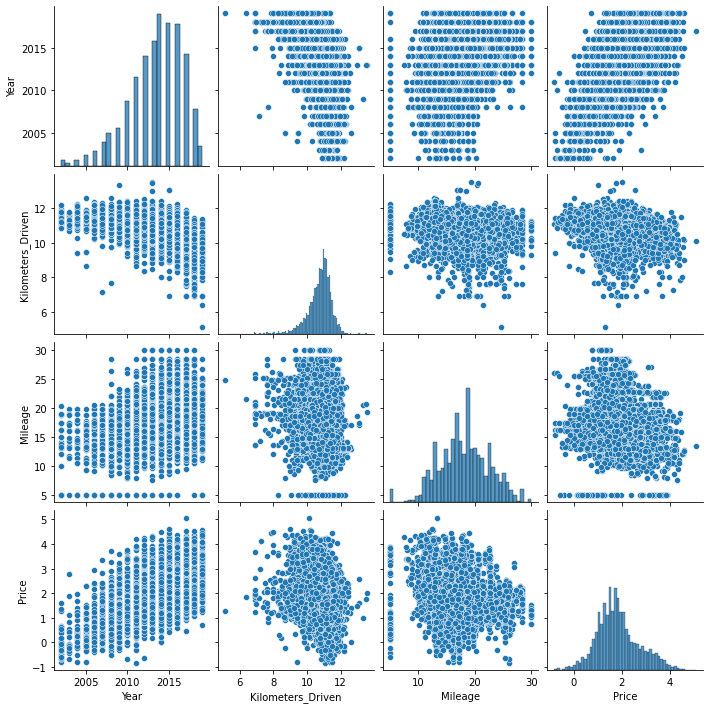

In [81]:
# 선형성이 존재
sns.pairplot(data[num_features])

#### 정규성 판단

In [79]:
pred = model.predict()
residual = y_train - model.predict()
zs = stats.zscore(residual)
(x, y), k = stats.probplot(zs)

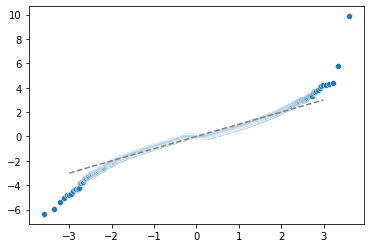

In [80]:
# 전반적으로 45기울기를 잘 따라가기 때문에 정규성을 만족한다고 판단
sns.scatterplot(x, y)
plt.plot([-3, 3], [-3, 3], '--', color = 'gray')

#### 등분산성 판단

Text(0, 0.5, 'residuals')

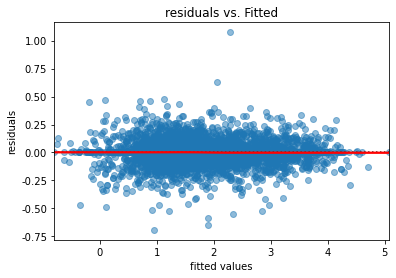

In [85]:
# 빨간색 선이 직전에 가까우므로 등분산성을 만족한다고 판단
fitted = model_trained.fittedvalues

sns.residplot(fitted, y_train, data = X_train, lowess = True, scatter_kws={'alpha':0.5}, line_kws={'color':'red'})

plt.title('residuals vs. Fitted')
plt.xlabel('fitted values')
plt.ylabel('residuals')